# OITNB Script Sentiment Analysis

This project works with the script of the pilot episode of Orange is the New Black. Using regular expressions, I take the script and identify instances of character names, as well as lines of dialogue, and then enter this information into a pandas database. After identifying all of the lines of dialogue, I preprocess all of the lines, and run sentiment analysis as well as part of speech tagging. Finally, using part of speech tagging and vocabulary as features, I use multiple logistical regression models to classify each line of dialogue as holding positive, neutral, or negative sentiment. 

## Using Regex to Identify Dialogue

To start, we can use regular expressions to identify where characters names are, as well as their spoken dialogue. Instead of concerning ourselves with stage directions, descriptions, etc. we can focus strictly on who is speaking and their dialogue. 

In [811]:
from nltk import ne_chunk, pos_tag, tokenize, corpus, word_tokenize, stem, PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import nltk
import re
import numpy as np

#nltk.download('stopwords')
#nltk.download('punkt')
nltk.download('vader_lexicon')

# Read in the OITNB script
file = open('oitnb.txt', 'r')
text = file.read()
text_split = text.split('\n')

# Use regular expressions in order to identify which lines are dialogue
import pandas as pd
import re

# Regex pattern to identify character names and lines
character_line_pattern = r'^(\w+)[\s\.,:]+(.+)$' # ONLY WANT FIRST NAMES

# Lists to store character names and lines
characters = []
lines = []

# Iterate over each dialogue line and extract character names and lines
for line in text_split:
    match = re.match(character_line_pattern, line)
    if match:
        character = match.group(1).lower()
        line_text = match.group(2)
        characters.append(character)
        lines.append(line_text)

# Create pandas DataFrame
lines = pd.DataFrame({
    'character': characters,
    'dialogue': lines
})
lines.head(45)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/myriahhodgson/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,character,dialogue
0,piper,Chapman: (Narrating) I've always loved getting...
1,piper,I love baths.
2,piper,I love showers.
3,piper,It's my happy place.
4,piper,Was my happy place.
5,man,over PA: All inmates in D dorm must be checked...
6,man,"Repeat, all inmates in D dorm must be checked ..."
7,piper,"Oh, I'll be out in a sec. I swear."
8,taystee,Jefferson: Mmm-hmm.
9,taystee,I'll wait. There best be some hot water left.


## Preprocessing the Dialogue

Next, we can preprocess our dialogue to be able to use it in our classifier. We will tokenize our dialogue into individual words (list of strings), convert all tokens to lowercase, and remove stop words from our lists (words that appear frequently which hold little significance, such as 'the').

Preprocessing:
(1) tokenization
(2) lowercasing
(3) removing stop words

In [812]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess(quote):
    """This function pre-processes quotes by:
        > Tokenizing
        > Lowercasing
        > Removing stop words
        The input of this function is a str - one singular quote."""
    no_punct = re.sub(r'[^a-zA-Z0-9\s]', '', quote.lower()) # Substitute all non-alphanumeric values for a space (which will be removed when tokenized)
    tokens = word_tokenize(no_punct) # Tokenize words
    # no_stop = [] # Get rid of all stop words
    #for token in tokens:
    #    if token not in stop_words:            # TODO -> Will not (?) be stemming words, because this alters the part of speech
    #        no_stop.append(stemmer.stem(token)) # After removing stop words, we can also stem our words
    return tokens

# Preprocess all dialogue in our table using the above function
preprocessed_dialogue = []
for quote in lines['dialogue']:
    preprocessed_dialogue.append(preprocess(quote))

# Add the preprocessed dialogue to our dataframe
lines['preprocessed_dialogue'] = preprocessed_dialogue

lines.head(30)

,character,dialogue,preprocessed_dialogue
0,piper,Chapman: (Narrating) I've always loved getting...,"[chapman, narrating, ive, always, loved, getti..."
1,piper,I love baths.,"[i, love, baths]"
2,piper,I love showers.,"[i, love, showers]"
3,piper,It's my happy place.,"[its, my, happy, place]"
4,piper,Was my happy place.,"[was, my, happy, place]"
5,man,over PA: All inmates in D dorm must be checked...,"[over, pa, all, inmates, in, d, dorm, must, be..."
6,man,"Repeat, all inmates in D dorm must be checked ...","[repeat, all, inmates, in, d, dorm, must, be, ..."
7,piper,"Oh, I'll be out in a sec. I swear.","[oh, ill, be, out, in, a, sec, i, swear]"
8,taystee,Jefferson: Mmm-hmm.,"[jefferson, mmmhmm]"
9,taystee,I'll wait. There best be some hot water left.,"[ill, wait, there, best, be, some, hot, water,..."


## Sentiment Analysis and Part of Speech Tagging

The package we have downloaded, nltk, includes both a sentiment intensity analyzer and a part of speech tagger. We can use each feature, respectively, to determine the intensity of each line of dialogue, as well as the part of speech correlated to each token in the list.

In [813]:
sia = SentimentIntensityAnalyzer()

pos_counts = []
compound = []
pos = []
neg = []
neutral = []

for tokens in lines['preprocessed_dialogue']: # TAG INDIVIDUAL TOKENS FOR PART OF SPEECH
    pos_tags = nltk.pos_tag(tokens) # get a part of speech tag for each token
    pos_count = Counter(tag for word, tag in pos_tags) # count how many of each part of speech for a given line
    pos_counts.append(pos_count)

for line in lines['dialogue']: # ANALYZE SENTIMENT OF AN ENTIRE LINE
    sentiment = sia.polarity_scores(line)
    compound.append(sentiment['compound'])
    pos.append(sentiment['pos'])
    neg.append(sentiment['neg'])
    neutral.append(sentiment['neu'])

lines[f'parts_of_speech'] = pos_counts
lines['compound_sentiment'] = compound
lines['positive_sentiment'] = pos
lines['negative_sentiment'] = neg
lines['neutral_sentiment'] = neutral

def overall_sentiment(x):
    """This function is for converting our compound sentiment score into categorical values."""
    if x > 0.01:
        return 'positive'
    if x < -0.01:
        return 'negative'
    return 'neutral'

lines['sentiments'] = lines['compound_sentiment'].apply(overall_sentiment)

lines

,character,dialogue,preprocessed_dialogue,parts_of_speech,compound_sentiment,positive_sentiment,negative_sentiment,neutral_sentiment,sentiments
0,piper,Chapman: (Narrating) I've always loved getting...,"[chapman, narrating, ive, always, loved, getti...","{'NN': 1, 'VBG': 2, 'JJ': 2, 'RB': 1, 'VBD': 1}",0.7650,0.569,0.000,0.431,positive
1,piper,I love baths.,"[i, love, baths]","{'NN': 1, 'VBP': 1, 'NNS': 1}",0.6369,0.808,0.000,0.192,positive
2,piper,I love showers.,"[i, love, showers]","{'NN': 1, 'VBP': 1, 'NNS': 1}",0.6369,0.808,0.000,0.192,positive
3,piper,It's my happy place.,"[its, my, happy, place]","{'PRP$': 2, 'JJ': 1, 'NN': 1}",0.5719,0.552,0.000,0.448,positive
4,piper,Was my happy place.,"[was, my, happy, place]","{'VBD': 1, 'PRP$': 1, 'JJ': 1, 'NN': 1}",0.5719,0.552,0.000,0.448,positive
...,...,...,...,...,...,...,...,...,...
592,demarco,Where's she going with that tray?! Get that gi...,"[wheres, she, going, with, that, tray, get, th...","{'NNS': 1, 'PRP': 1, 'VBG': 1, 'IN': 2, 'DT': ...",0.0000,0.000,0.000,1.000,neutral
593,nicky,She'll figure it out.,"[shell, figure, it, out]","{'NN': 2, 'PRP': 1, 'RP': 1}",0.0000,0.000,0.000,1.000,neutral
594,morello,Was she really in the shower this morning?,"[was, she, really, in, the, shower, this, morn...","{'VBD': 1, 'PRP': 1, 'RB': 1, 'IN': 1, 'DT': 2...",0.0000,0.000,0.000,1.000,neutral
595,alex,"Maybe this is a bad time to say hi, huh?","[maybe, this, is, a, bad, time, to, say, hi, huh]","{'RB': 1, 'DT': 2, 'VBZ': 1, 'JJ': 1, 'NN': 3,...",-0.5423,0.000,0.304,0.696,negative


## Using Logistic Regression to Predict Sentiment

Now that we have our features extracted (parts of speech and vocabulary), we can use them to train a few different classifiers which predict the sentiment of a line of dialogue. To be able to test various features, and their accuracy in classification, we will train three different classifiers and compare results: (1) a classifier that uses part of speech as its only feature, (2) a classifier that uses vocabulary as its only feature, and (3) a classifier that uses both vocabulary and part of speech as features. After using these three classifiers, we can evaluate the accuracy of each to decide the various strengths of each classifier.

To start, let's make separate dataframes of each of our features; when we train the classifier that uses both features, we will concatenate these dataframes into one singular one to use with our classifier.

In [814]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

"""Make separate dataframes for each of our features, and then concatenate them:"""

# convert POS features to a separate dataframe
pos_df = pd.json_normalize(lines['parts_of_speech'])
pos_df = pos_df.fillna(0) # any missing tag gets the count of 0

# initialize our vectorizer
vectorizer = CountVectorizer()

# fit and transform the dialogue text to get vocabulary features; to do so, the preprocessed dialogue needs to be one string again, not tokens
ppdialogue_str = [" ".join(tokens) for tokens in lines['preprocessed_dialogue']]
lines['preprocessed_dialogue_string'] = ppdialogue_str # make it one string again!

vocab_features = vectorizer.fit_transform(lines['preprocessed_dialogue_string'])

# convert to dataframe
vocab_df = pd.DataFrame(vocab_features.toarray(), columns=vectorizer.get_feature_names_out())

Our first classifier uses part of speech as its feature:

In [815]:
# X is part of speech
X = pos_df

# our target variable, y, is character - what we are attempting to predict
y = lines['sentiments']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # split our data into a train and test set

# Initialize and train our classifier 
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

# Evaluate the classifier
print("Part of Speech as Feature:\n")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

pos_features = classification_report(y_test, y_pred, output_dict=True)
pos_report_df = pd.DataFrame(pos_features)
pos_report_df

Part of Speech as Feature:

Confusion Matrix:
 [[ 6 13  8]
 [ 3 47  4]
 [ 4 26  9]]

Classification Report:
               precision    recall  f1-score   support

    negative       0.46      0.22      0.30        27
     neutral       0.55      0.87      0.67        54
    positive       0.43      0.23      0.30        39

    accuracy                           0.52       120
   macro avg       0.48      0.44      0.42       120
weighted avg       0.49      0.52      0.47       120



,negative,neutral,positive,accuracy,macro avg,weighted avg
precision,0.461538,0.546512,0.428571,0.516667,0.478874,0.489062
recall,0.222222,0.870370,0.230769,0.516667,0.441121,0.516667
f1-score,0.300000,0.671429,0.300000,0.516667,0.423810,0.467143
support,27.000000,54.000000,39.000000,0.516667,120.000000,120.000000


Our next uses vocabulary as its feature:

In [816]:
# X is vocabulary
X = vocab_df

# our target variable, y, is character - what we are attempting to predict
y = lines['sentiments']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # split our data into a train and test set

# Initialize and train our classifier 
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

# Evaluate the classifier
print("Vocabulary as Feature:\n")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

vocab_as_feature = classification_report(y_test, y_pred, output_dict=True)
vocab_report_df = pd.DataFrame(vocab_as_feature)
vocab_report_df

Vocabulary as Feature:

Confusion Matrix:
 [[13 10  4]
 [ 1 49  4]
 [ 3 14 22]]

Classification Report:
               precision    recall  f1-score   support

    negative       0.76      0.48      0.59        27
     neutral       0.67      0.91      0.77        54
    positive       0.73      0.56      0.64        39

    accuracy                           0.70       120
   macro avg       0.72      0.65      0.67       120
weighted avg       0.71      0.70      0.69       120



,negative,neutral,positive,accuracy,macro avg,weighted avg
precision,0.764706,0.671233,0.733333,0.7,0.723091,0.712447
recall,0.481481,0.907407,0.564103,0.7,0.650997,0.700000
f1-score,0.590909,0.771654,0.637681,0.7,0.666748,0.687445
support,27.000000,54.000000,39.000000,0.7,120.000000,120.000000


And lastly, our final classifier uses both part of speech and vocabulary as features:

In [817]:
# combine all features to make X
X = pd.concat([pos_df, vocab_df], axis=1)

# our target variable, y, is character - what we are attempting to predict
y = lines['sentiments']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # split our data into a train and test set

# Initialize and train our classifier 
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

# Evaluate the classifier
print("Both Part of Speech and Vocabulary as Features:\n")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

both_features = classification_report(y_test, y_pred, output_dict=True)
both_df = pd.DataFrame(both_features)
both_df

Both Part of Speech and Vocabulary as Features:

Confusion Matrix:
 [[12  7  8]
 [ 2 49  3]
 [ 3 12 24]]

Classification Report:
               precision    recall  f1-score   support

    negative       0.71      0.44      0.55        27
     neutral       0.72      0.91      0.80        54
    positive       0.69      0.62      0.65        39

    accuracy                           0.71       120
   macro avg       0.70      0.66      0.67       120
weighted avg       0.71      0.71      0.70       120



,negative,neutral,positive,accuracy,macro avg,weighted avg
precision,0.705882,0.720588,0.685714,0.708333,0.704062,0.705945
recall,0.444444,0.907407,0.615385,0.708333,0.655745,0.708333
f1-score,0.545455,0.803279,0.648649,0.708333,0.665794,0.695013
support,27.000000,54.000000,39.000000,0.708333,120.000000,120.000000


## Evaluation of Accuracy

Looking at the classification reports provided for part of speech and vocabulary as separate, individual features, it appears that in all aspects vocabulary is more proficient in predicting sentiment than part of speech.
Part of speech, alone, appears to be a very poor feature to use in order to predict the sentiment of a phrase of dialogue. 

It also appears that using both part of speech and vocabulary as features may not always be more effective than simply using only vocabulary as one, singular feature in predicting the sentiments of our dialogues. Let's review what each of these terms mean in order to determine the strengths of our classifiers and where they fall short, in order to use the most effecient model(s):

#### Precision
Precision is determined by all of the positive predictions made by our classifier. Of all of the predictions we made as positive, how many were actually positive?
Mathematically, precision is determined by (# of True Positives) / (# of True Positives + # of False Positives). Essentially, we take the number of values we marked as positive and which are actually positive, and divide that by the total number of values we indicated as positive (whether or not we were actually correct).

Ex:     If our classifier predicts a statement as negative, what is the probability that the statement is actually negative?
#### Recall
Recall focuses on how many positive predictions our classifier made, based on all actually positive instances. Of all instances which are actually positive, how many did our classifier indicate as positive?
Mathematically, recall is determined by (# of True Positives) / (# of True Positives + # of False Negatives). False Negatives are the values which are actually positive, but our classifier marked as negative. Essentially, we take the number of values which we marked as positive and are actually positive, and divide that by the total number of values which are in actuality positive.

Ex:     If a statement is neutral, what is the probability that our classifier predicted the statement as neutral?

#### F1-Score
An f1-score indicates the harmonic mean of precision and recall, making it a good measurement in that it accounts for both false positives and false negatives. 
#### Support
Support measures how many instances in the dataset are of each class.

Ex:     In classifying based upon both part of speech and vocabulary as features, there were 18 instances of negative sentiments.
#### Accuracy
Accuracy is the overall proportion of correctly predicted instances, among all instances. Which instances were classified correctly?

#### Macro Average
Macro average is the average of precision, recall, and f-1 scores.
#### Weighted Average
The weighted average takes into consideration the class distribution of our values, by weighing the metrics by the support of each class. It considers the number of instances of each class while taking its average.  



Now that we have a grasp of what each measurement of accuracy truly means, lets put the classification reports of each of our trials side by side to determine which may be the strongest, and where our models may fall short:

In [818]:
print(f"Part of Speech Classification Report")
print(f"{pos_report_df}\n")

print(f"Vocabulary Classification Report")
print(f"{vocab_report_df}\n")

print(f"Part of Speech & Vocabulary Classification Report")
print(f"{both_df}")

Part of Speech Classification Report
            negative    neutral   positive  accuracy   macro avg  weighted avg
precision   0.461538   0.546512   0.428571  0.516667    0.478874      0.489062
recall      0.222222   0.870370   0.230769  0.516667    0.441121      0.516667
f1-score    0.300000   0.671429   0.300000  0.516667    0.423810      0.467143
support    27.000000  54.000000  39.000000  0.516667  120.000000    120.000000

Vocabulary Classification Report
            negative    neutral   positive  accuracy   macro avg  weighted avg
precision   0.764706   0.671233   0.733333       0.7    0.723091      0.712447
recall      0.481481   0.907407   0.564103       0.7    0.650997      0.700000
f1-score    0.590909   0.771654   0.637681       0.7    0.666748      0.687445
support    27.000000  54.000000  39.000000       0.7  120.000000    120.000000

Part of Speech & Vocabulary Classification Report
            negative    neutral   positive  accuracy   macro avg  weighted avg
precision

As mentioned above, our classifier which simply uses part of speech is poor. In terms of weighted and macro averages, our classifier which simply uses vocabulary as a feature score rather than both vocabulary and part of speech scores equally or more accurately in various metrics (precision, recall, f1-score). The accuracy of both of these models is similar, at 0.7 and 0.708. 

Let's conduct a paired t-test using these metrics to determine whether or not there is a distinction in accuracy in these last two classifiers, or if the variability could potentially be due to chance.

In [819]:
from scipy import stats

# Weighted averages for these two classifiers includes their precision, recall, f1-score, and support
vocab_weighted_averages = np.array(vocab_report_df['weighted avg'])
pos_and_vocab_weighted_averages = np.array(both_df['weighted avg'])

t_stat, p_val = stats.ttest_rel(vocab_weighted_averages, pos_and_vocab_weighted_averages)

print(f"T-statistic: {t_stat}\nP-value: {p_val}")

T-statistic: -0.6716611209378411
P-value: 0.5498945956849527


Because our T-statistic is relatively small, and our P-value is quite large (greater than both a = 0.05 or 0.10), we do not have enough evidence to conclude that either model is entirely more accurate than another. Such variation could be due to chance. The probability of observing a distance at least as extreme as the one which we found, assuming there is no difference between our two classifiers is roughly 0.54. We do not have statistically significant evidence of the difference being due to something other than random chance.

Let's confirm that there is a significant difference between our part of speech classifier and vocabulary classifier, though, after visually seeing such a stark contrast:

In [820]:
# Weighted averages for these two classifiers includes their precision, recall, f1-score, and support
vocab_weighted_averages = np.array(vocab_report_df['weighted avg'])
pos_weighted_averages = np.array(pos_report_df['weighted avg'])

t_stat, p_val = stats.ttest_rel(vocab_weighted_averages, pos_weighted_averages)

print(f"T-statistic: {t_stat}\nP-value: {p_val}")

T-statistic: 2.955525695226782
P-value: 0.05975845149952416


Our T-statistic is now greater, and our P-value of ~ 0.06 indicates statistical significance of there being a difference between classifiers. At an alpha = 0.10 level, we have enough evidence to reject a null hypothesis that there is no difference in ability to classify based on vocabulary or part of speech. The probability of observing a distance at least as extreme as the one we found, assuming there is no difference between our classifiers, is approx. 0.0597.

# Piper or Not?

Another interesting component to this project could be training a classifier which determines which character is speaking. With more data, I believe we would be able to train a classifier which identifies the central characters; with only the dialogue available from the first pilot episode, this is most likely too extensive of an endeavour. With how frequently the protagonist, Piper, speaks in this episode, are we able to effective classify whether or not she is the character speaking?

Let's start by adding a column to our initial dataframe which determines whether or not Piper is the character speaking:

In [821]:
piper_bool = lines['character'] == ('piper')
lines['piper'] = piper_bool
lines

,character,dialogue,preprocessed_dialogue,parts_of_speech,compound_sentiment,positive_sentiment,negative_sentiment,neutral_sentiment,sentiments,preprocessed_dialogue_string,piper
0,piper,Chapman: (Narrating) I've always loved getting...,"[chapman, narrating, ive, always, loved, getti...","{'NN': 1, 'VBG': 2, 'JJ': 2, 'RB': 1, 'VBD': 1}",0.7650,0.569,0.000,0.431,positive,chapman narrating ive always loved getting clean,True
1,piper,I love baths.,"[i, love, baths]","{'NN': 1, 'VBP': 1, 'NNS': 1}",0.6369,0.808,0.000,0.192,positive,i love baths,True
2,piper,I love showers.,"[i, love, showers]","{'NN': 1, 'VBP': 1, 'NNS': 1}",0.6369,0.808,0.000,0.192,positive,i love showers,True
3,piper,It's my happy place.,"[its, my, happy, place]","{'PRP$': 2, 'JJ': 1, 'NN': 1}",0.5719,0.552,0.000,0.448,positive,its my happy place,True
4,piper,Was my happy place.,"[was, my, happy, place]","{'VBD': 1, 'PRP$': 1, 'JJ': 1, 'NN': 1}",0.5719,0.552,0.000,0.448,positive,was my happy place,True
...,...,...,...,...,...,...,...,...,...,...,...
592,demarco,Where's she going with that tray?! Get that gi...,"[wheres, she, going, with, that, tray, get, th...","{'NNS': 1, 'PRP': 1, 'VBG': 1, 'IN': 2, 'DT': ...",0.0000,0.000,0.000,1.000,neutral,wheres she going with that tray get that girl ...,False
593,nicky,She'll figure it out.,"[shell, figure, it, out]","{'NN': 2, 'PRP': 1, 'RP': 1}",0.0000,0.000,0.000,1.000,neutral,shell figure it out,False
594,morello,Was she really in the shower this morning?,"[was, she, really, in, the, shower, this, morn...","{'VBD': 1, 'PRP': 1, 'RB': 1, 'IN': 1, 'DT': 2...",0.0000,0.000,0.000,1.000,neutral,was she really in the shower this morning,False
595,alex,"Maybe this is a bad time to say hi, huh?","[maybe, this, is, a, bad, time, to, say, hi, huh]","{'RB': 1, 'DT': 2, 'VBZ': 1, 'JJ': 1, 'NN': 3,...",-0.5423,0.000,0.304,0.696,negative,maybe this is a bad time to say hi huh,False


Let's concatenate any appropriate DataFrames to use as features (vocabulary and sentiment):

In [826]:
X = pd.concat([lines[['compound_sentiment']], vocab_df, pos_df], axis=1)

y = lines['piper']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_prediction = model.predict(X_test)

# Evaluate the classifier
piper_report = classification_report(y_test, y_prediction, output_dict=True)
piper_report_df = pd.DataFrame(piper_report)
piper_report_df


,False,True,accuracy,macro avg,weighted avg
precision,0.697674,0.441176,0.625,0.569425,0.610038
recall,0.759494,0.365854,0.625,0.562674,0.625000
f1-score,0.727273,0.400000,0.625,0.563636,0.615455
support,79.000000,41.000000,0.625,120.000000,120.000000


It appears even simply trying to determine whether or not a character is the central character, Piper, is very poor. More data to draw conclusions from, or more advanced analyses other than simple Logistic Regression, appear to be neccessary in order to produce a successful classifier which determines character––even a character as essential as protagonist Piper. None of our metrics reach an accuracy score of at least 0.7.

# Other Considerations

Returning to our classifiers which predict sentiment, let's look at another factor which might also correlate to the labeling of each line as positive, neutral or negative: its length. Let's add a column to our dataframe which records the length of each line:

In [823]:
lines
line_lengths = []
for line in lines['preprocessed_dialogue']:
    line_lengths.append(len(line))

lines['line lengths'] = line_lengths
lines

,character,dialogue,preprocessed_dialogue,parts_of_speech,compound_sentiment,positive_sentiment,negative_sentiment,neutral_sentiment,sentiments,preprocessed_dialogue_string,piper,line lengths
0,piper,Chapman: (Narrating) I've always loved getting...,"[chapman, narrating, ive, always, loved, getti...","{'NN': 1, 'VBG': 2, 'JJ': 2, 'RB': 1, 'VBD': 1}",0.7650,0.569,0.000,0.431,positive,chapman narrating ive always loved getting clean,True,7
1,piper,I love baths.,"[i, love, baths]","{'NN': 1, 'VBP': 1, 'NNS': 1}",0.6369,0.808,0.000,0.192,positive,i love baths,True,3
2,piper,I love showers.,"[i, love, showers]","{'NN': 1, 'VBP': 1, 'NNS': 1}",0.6369,0.808,0.000,0.192,positive,i love showers,True,3
3,piper,It's my happy place.,"[its, my, happy, place]","{'PRP$': 2, 'JJ': 1, 'NN': 1}",0.5719,0.552,0.000,0.448,positive,its my happy place,True,4
4,piper,Was my happy place.,"[was, my, happy, place]","{'VBD': 1, 'PRP$': 1, 'JJ': 1, 'NN': 1}",0.5719,0.552,0.000,0.448,positive,was my happy place,True,4
...,...,...,...,...,...,...,...,...,...,...,...,...
592,demarco,Where's she going with that tray?! Get that gi...,"[wheres, she, going, with, that, tray, get, th...","{'NNS': 1, 'PRP': 1, 'VBG': 1, 'IN': 2, 'DT': ...",0.0000,0.000,0.000,1.000,neutral,wheres she going with that tray get that girl ...,False,11
593,nicky,She'll figure it out.,"[shell, figure, it, out]","{'NN': 2, 'PRP': 1, 'RP': 1}",0.0000,0.000,0.000,1.000,neutral,shell figure it out,False,4
594,morello,Was she really in the shower this morning?,"[was, she, really, in, the, shower, this, morn...","{'VBD': 1, 'PRP': 1, 'RB': 1, 'IN': 1, 'DT': 2...",0.0000,0.000,0.000,1.000,neutral,was she really in the shower this morning,False,8
595,alex,"Maybe this is a bad time to say hi, huh?","[maybe, this, is, a, bad, time, to, say, hi, huh]","{'RB': 1, 'DT': 2, 'VBZ': 1, 'JJ': 1, 'NN': 3,...",-0.5423,0.000,0.304,0.696,negative,maybe this is a bad time to say hi huh,False,10


After adding the line column, let's run some descriptive statistics on all of the lines that fit into each sentiment category, and graph them:

Positive Line Lengths:
count    196.000000
mean      10.357143
std       10.853098
min        1.000000
25%        3.000000
50%        7.000000
75%       13.250000
max       71.000000
Name: line lengths, dtype: float64

Neutral Line Lengths:
count    290.000000
mean       5.724138
std        4.791837
min        1.000000
25%        2.000000
50%        5.000000
75%        7.750000
max       40.000000
Name: line lengths, dtype: float64

Negative Line Lengths:
count    111.000000
mean      12.630631
std       15.581415
min        1.000000
25%        4.000000
50%        8.000000
75%       15.000000
max       88.000000
Name: line lengths, dtype: float64



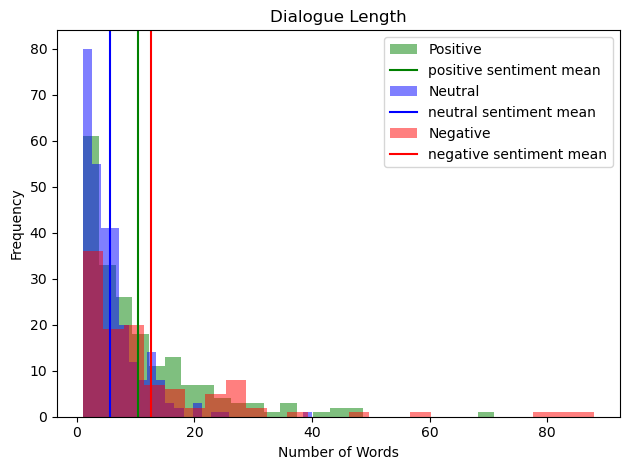

In [824]:
import matplotlib.pyplot as plt

x_range = (0, np.max(lines['line lengths']))

positive = lines[lines['sentiments'] == 'positive']['line lengths']
neutral = lines[lines['sentiments'] == 'neutral']['line lengths']
negative = lines[lines['sentiments'] == 'negative']['line lengths']

#fig, [ax0, ax1, ax2] = plt.subplots(1, 3, figsize=(16, 4))

plt.hist(positive, color='green', alpha=0.5, bins=25, label='Positive')
plt.axvline(np.mean(positive), color='green', label='positive sentiment mean')
plt.hist(neutral, color='blue', alpha=0.5, bins=25, label='Neutral')
plt.axvline(np.mean(neutral), color='blue', label='neutral sentiment mean')
plt.hist(negative, color='red', alpha=0.5, bins=25, label='Negative')
plt.axvline(np.mean(negative), color='red', label='negative sentiment mean')

plt.title('Dialogue Length')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()#; ax1.legend(); ax2.legend()
plt.tight_layout()

print(f"Positive Line Lengths:\n{positive.describe()}\n")
print(f"Neutral Line Lengths:\n{neutral.describe()}\n")
print(f"Negative Line Lengths:\n{negative.describe()}\n")


It appears that, while all three distributions are significantly right-skewed, their center and spreads differ. The distribution of neutral sentiments has a higher peak closer to 0, and its maximum is 40 tokens––much less than that of the other two distributions. Although we stripped our phrases of most stop words, it still appears that it may take a longer sentence length in order to indicate sentiment. It is worth noting that the negative sentiment distribution has both the smallest peak and largest spread out of all three distributions (std of 15.58).

Text(0, 0.5, 'Frequency')

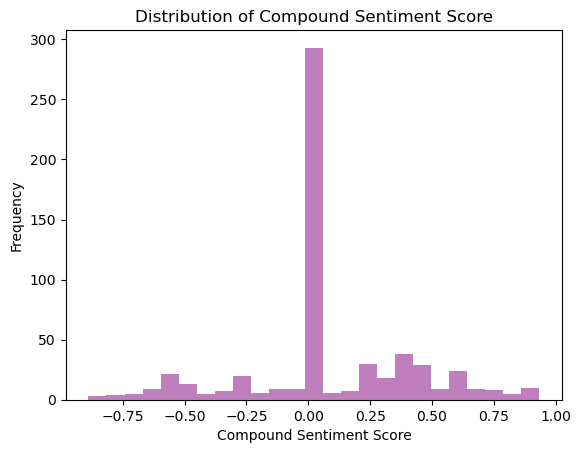

In [825]:
plt.hist(lines['compound_sentiment'], bins=25, color='purple', alpha=0.5)
plt.title('Distribution of Compound Sentiment Score')
plt.xlabel('Compound Sentiment Score'); plt.ylabel('Frequency')


Another consideration in our classifier is the distribution of compound sentiment scores. Despite its spread, the distribution has one singular, very tall peak directly in the center of its distribution. Such a peak makes me question exactly how we should divide the sentiment classes into qualitative categories. If a line of dialogue is marked as 'positive' or 'negative', yet its score is still quite close to the center, it may be more difficult for our classifier to interpret.